In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
import cv2

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#目前问题：尝试LRN的实现；以及目前的效果都很不好，需要考虑使用数据增强，如果仍然不行的话就要换网络，试试VGG的效果
#另一个问题是使用binary_crossentropy二分类交叉熵会报错，目前只能用多分类的，不知道这个问题解决能不能提高成功率
#了解one-hot编码，应用随机增强
#原来灰度图不是只有0和1啊卧槽，我还需要进行标准化，这是个关键问题，和数据增强一起
#目前对于数据集，验证集和测试集的思路有点混乱，明明val_accruate挺高的，但是结果就很低，为什么很奇怪，我怀疑是我哪里出线错误了？？？？
#目前先尝试直接调用官方的结构进行处理，如果也不行说明不是神经网络的问题，是我的设置有问题
#图片格式要改成224，224，尝试一下————试试用现在的三维图效果是不是更好一些
#尝试把目前的框架应用一下多分类，看有没有效果
#需要整理一下目前的所有程序和文档了，有些复杂，理清明天工作需要的部分

In [2]:
alldata= np.load(file="alldata_3D.npy")
alllable=pd.read_csv('label_binary.csv')
label=[]
for i in range(3000):
    data = alllable['label'][i]
    if data == 'no_tumor':
        #label.append(data)
        label.append(0)
    else:
        #label.append('meningioma_tumor')
        label.append(1)
label = np.array(label)

In [3]:
class_names1 = ['tumor','no_tumor']

In [4]:
#加入超参数和数据增强部分

train_image_generator = keras.preprocessing.image.ImageDataGenerator( rescale=1./255,
                                            rotation_range=40,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            zoom_range=0.2,
                                            horizontal_flip=True,
                                            fill_mode='nearest')
validation_image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [5]:
#按照6：2：2的结构来分成训练集，验证集和测试集
alldata = np.array(alldata, dtype="float") / 255.0 #简单做下scale处理，没有涉及到归一化的数据，从结果上看没什么价值
train_images,test_images,train_labels,test_labels=train_test_split(alldata,label,test_size=0.2,random_state=0)
train_images,val_images,train_labels,val_labels=train_test_split(train_images,train_labels,test_size=0.25,random_state=0)

In [6]:
class LRN(keras.layers.Layer):
    def __init__(self):
        super(LRN, self).__init__()
        self.depth_radius=2
        self.bias=1
        self.alpha=1e-4
        self.beta=0.75
    def call(self,x):
        return tf.nn.lrn(x,depth_radius=self.depth_radius,
                         bias=self.bias,alpha=self.alpha,
                         beta=self.beta)

In [7]:
#conv1+pool1+lrn1-->conv2+pool2+lrn2-->conv3-->conv4-->conv5+pool5-->fc1-->fc2-->fc3 Alexnet
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=96, kernel_size=(11,11),strides=4,activation='relu',padding='same',input_shape=(224,224,3)))
model.add(keras.layers.MaxPool2D(pool_size=(3,3),strides=2))
model.add(LRN())
model.add(keras.layers.Conv2D(filters=256,kernel_size=(5,5),strides=1,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(3,3),strides=2))
model.add(LRN())
model.add(keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=1,activation='relu',padding='same'))
model.add(keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=1,activation='relu',padding='same'))
model.add(keras.layers.Conv2D(filters=256,kernel_size=(3,3),strides=1,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(3,3),strides=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4096,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4096,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2,activation="softmax")) #最后一步觉得输出数据的，我怎么特么直接抄了个1000出来
model.summary()
#在 input_shape 中不包含数据的 batch 大小。
#model.get_config() 返回包含模型配置信息的字典。
#from_logits=True 表示 crossEntropy 层的输入是正常的张量/logits，而如果 from_logits=False，则表示输入是一个概率，通常你应该在最后一层有一些 softmax 激活

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
lrn (LRN)                    (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
lrn_1 (LRN)                  (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

In [8]:
'''model = keras.models.Sequential()  #VGG
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(204,204,1)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.summary()'''

"model = keras.models.Sequential()  #VGG\nmodel.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(204,204,1)))\nmodel.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))\nmodel.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))\nmodel.add(keras.layers.Dropout(0.25))\nmodel.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))\nmodel.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))\nmodel.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))\nmodel.add(keras.layers.Dropout(0.25))\nmodel.add(keras.layers.Flatten())\nmodel.add(keras.layers.Dense(256, activation='relu'))\nmodel.add(keras.layers.Dropout(0.5))\nmodel.add(keras.layers.Dense(10, activation='softmax'))\nsgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)\nmodel.summary()"

In [9]:
#train_images = train_images.reshape((1800, 204, 204, 1))
#test_images=test_images.reshape((600, 204, 204, 1))
#val_images=test_images.reshape((600, 204, 204, 1))  
#损失函数应该改一下，这个是针对多分类的，二分类的不一样binary_crossentropy，优化器可能也要改
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
#使用二分类交叉熵会报错，这是个大问题？需要解决
#epoch 迭代次数
#model.fit 方法返回一个 History 回调，它具有包含连续误差的列表和其他度量的 history 属性。
history =model.fit(train_images, train_labels, batch_size=32, epochs=15,validation_data=(val_images, val_labels))

Epoch 1/15
57/57 [==============================] - 8s 57ms/step - loss: 0.4732 - accuracy: 0.8350 - val_loss: 0.4330 - val_accuracy: 0.8667
Epoch 2/15
57/57 [==============================] - 2s 37ms/step - loss: 0.3669 - accuracy: 0.8472 - val_loss: 0.2866 - val_accuracy: 0.8683
Epoch 3/15
57/57 [==============================] - 2s 36ms/step - loss: 0.2863 - accuracy: 0.8511 - val_loss: 0.3329 - val_accuracy: 0.8650
Epoch 4/15
57/57 [==============================] - 2s 38ms/step - loss: 0.3351 - accuracy: 0.8656 - val_loss: 0.2888 - val_accuracy: 0.8683
Epoch 5/15
57/57 [==============================] - 2s 38ms/step - loss: 0.2616 - accuracy: 0.8756 - val_loss: 0.2512 - val_accuracy: 0.8650
Epoch 6/15
57/57 [==============================] - 2s 35ms/step - loss: 0.2543 - accuracy: 0.8828 - val_loss: 0.2876 - val_accuracy: 0.8867
Epoch 7/15
57/57 [==============================] - 2s 38ms/step - loss: 0.2415 - accuracy: 0.8778 - val_loss: 0.2387 - val_accuracy: 0.8850
Epoch 8/15
57

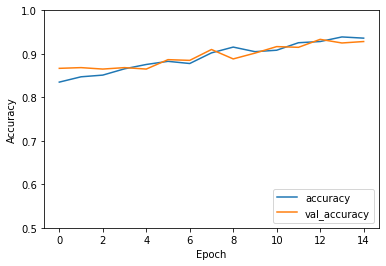

19/19 [==============================] - 0s 13ms/step - loss: 0.2184 - accuracy: 0.9133
0.9133333563804626


In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)
print(test_acc)

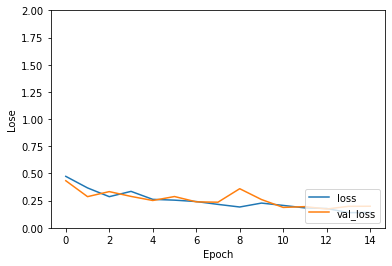

0.21840545535087585


In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Lose')
plt.ylim([0, 2])
plt.legend(loc='lower right')
plt.show()
print(test_loss)